# What caused the Yammer engagement dip in August 2014?

# Problem
Yammer experienced a drop in user engagment near the beginning of August 2014. Can user data identify possible causes for the drop in engagement? 

# The Data
The data is contained in three .csv datasets. 
1. A "users" dataset that contains information related to the creation of user accounts: userID, timestamp, companyID, language, activation, account state. 
2. An "emails" dataset that contains user engagment data related to "Weekly digest" emails: userID, timestamp, action (sent email, opened email, clicked through email), userType.
3. An "events" that contains user engagement data related to website activity: userID, timestamp, eventType, eventName, location, device, userType 

# My Solution

My solution was to plot 7-day rolling averages for a variety of key indicators (account creation, location, device type, email opening, email clickthrough) and to visually look for significant drops in those indicators.  


# Results

I found that drop in user engagement was closely associated with a drop in "email clickthrough", which dropped 25% in August 2014. Overall, the drop in user engagement was unrelated to email opens, new account creation, specific location, or specific device type. 

# Actionable advice

Consider strategic location of URL within Weekly Digest emails. Was there a change to the URL location to the Weekly Digest emails in August 2014?

In [525]:
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

In [395]:
users = pd.read_csv('/home/rubisco/Desktop/data-challenges/yammer/yammer_users.csv')
emails = pd.read_csv('/home/rubisco/Desktop/data-challenges/yammer/yammer_emails.csv')
events = pd.read_csv('/home/rubisco/Desktop/data-challenges/yammer/yammer_events.csv')
rollup = pd.read_csv('/home/rubisco/Desktop/data-challenges/yammer/dimension_rollup_periods.csv')

In [508]:
# Bin all events by the day they occurred

# binning the EVENTS data
month_day = []  
for element in events['occurred_at']:
    month_day.append(str(element[0:10]))  # Pulling out MONTH and DAY information
day_df = pd.DataFrame(month_day) #Turning MONTH/DAY list into DataFrame
events_day = events.join(day_df) #Joining MONTH/DAY DF with the original DF 
daily_counts = pd.DataFrame(events_day.groupby([0]).count()['occurred_at']).reset_index() #Counting the 
counts = daily_counts['occurred_at']

month_day = [] # binning the EMAILS data
for element in emails['occurred_at']:
    month_day.append(str(element[0:10]))
day_df = pd.DataFrame(month_day)
emails_day = emails.join(day_df)


month_day = [] #binning ALL USERS data
for element in users['created_at']:
    month_day.append(str(element[0:10]))
day_df = pd.DataFrame(month_day, columns=['date'])
users_day = users.join(day_df)
user_daily_counts = pd.DataFrame(users_day.groupby(['date']).count()['created_at']).reset_index().reset_index()
user_counts = user_daily_counts['created_at']

month_day = [] #binningd ACTIVE USERS data
active_set = users.loc[users['state'] == 'active']
for element in active_set['created_at']:
        month_day.append(str(element[0:10]))
day_df = pd.DataFrame(month_day, columns=['date'])
active_users_day = active_set.join(day_df)
active_user_daily_counts = pd.DataFrame(active_users_day.groupby(['date']).count()['created_at']).reset_index().reset_index()
active_user_counts = active_user_daily_counts['created_at']

In [509]:
users.head()

user_id           created_at  company_id language         activated_at  \
0      0.0  2013-01-01 20:59:39      5737.0  english  2013-01-01 21:01:07   
1      1.0  2013-01-01 13:07:46        28.0  english                  NaN   
2      2.0  2013-01-01 10:59:05        51.0  english                  NaN   
3      3.0  2013-01-01 18:40:36      2800.0   german  2013-01-01 18:42:02   
4      4.0  2013-01-01 14:37:51      5110.0   indian  2013-01-01 14:39:05   

     state  
0   active  
1  pending  
2  pending  
3   active  
4   active

In [513]:
# calculate a weekly moving average of engagement
moving_average = []
date = []
i = 6
while i < 123:
    average = (counts[i] + counts[i-1] + counts[i-2] + counts[i-3] + counts[i-4] + counts[i-5] + counts[i-6])/7
    day = daily_counts[0][i]
    moving_average.append(average)
    date.append(day)
    i += 1
window = pd.DataFrame(moving_average, columns=['count']).reset_index()
month_day1 = pd.DataFrame(date, columns=['date']).reset_index()
window.head()

index        count
0      0  2652.428571
1      1  2682.428571
2      2  2628.857143
3      3  2606.000000
4      4  2630.857143

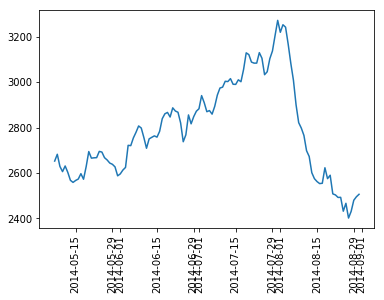

In [517]:
#Plot of weekly-averaged engagement to recreate engagement drop

date = []
for element in month_day1['date']:
    date.append(pd.to_datetime(element))

plt.xticks(rotation=90)
plt.plot(date, window['count']);

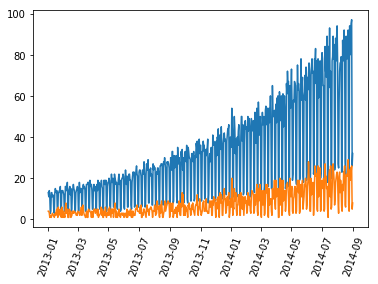

In [494]:
#Users created every day

date = []
date1 = []
for element in user_daily_counts['date']:
    date.append(pd.to_datetime(element))
for element in active_user_daily_counts['date']:
    date1.append(pd.to_datetime(element))
plt.xticks(rotation=70)
plt.plot(date, user_daily_counts['created_at'])
plt.plot(date1, active_user_daily_counts['created_at']);

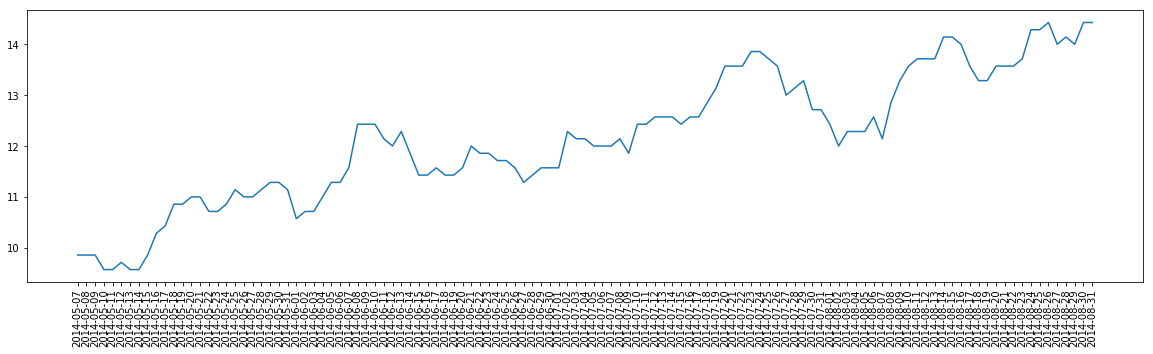

In [545]:
# Weekly moving average for NEW ACCOUNTS 

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

moving_average = []
date = []
i = 6
while i < 123:
    average = (user_counts[i] + user_counts[i-1] + user_counts[i-2] + user_counts[i-3] + user_counts[i-4] + user_counts[i-5] + user_counts[i-6])/7
    day = daily_counts[0][i]
    moving_average.append(average)
    date.append(day)
    i += 1
window = pd.DataFrame(moving_average).reset_index()
month_day = pd.DataFrame(date).reset_index()
#Plot of weekly-averaged engagement to recreate 
fig, ax = plt.subplots(figsize=(20, 5))
plt.xticks(rotation=90)
plt.plot(date, window[0]);

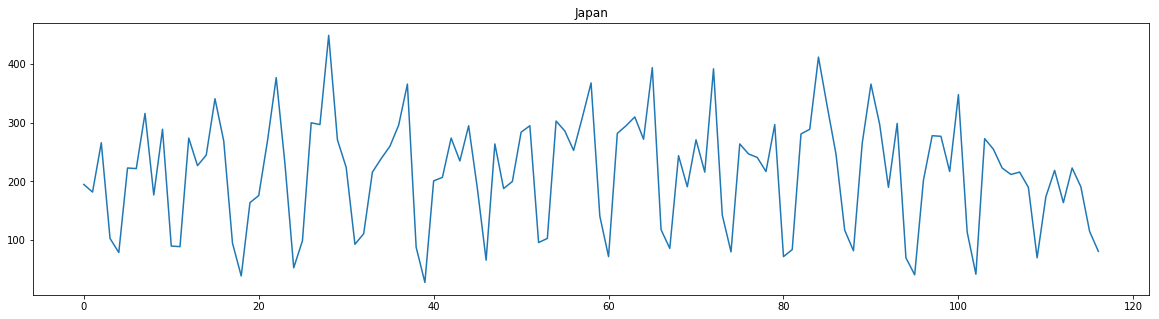

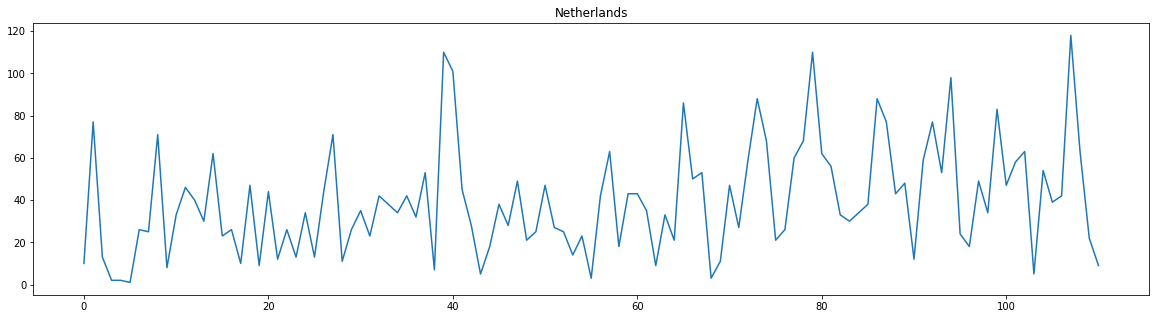

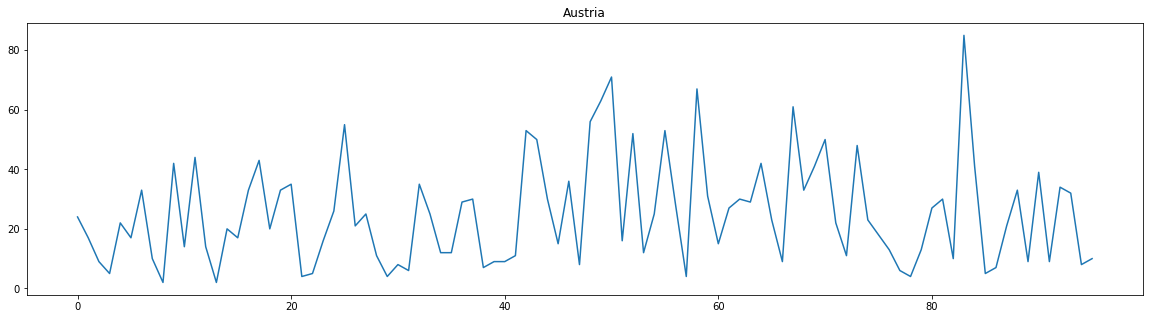

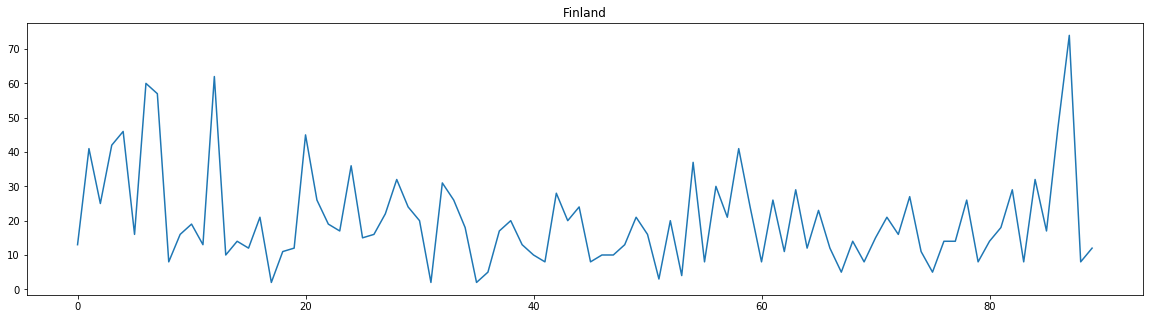

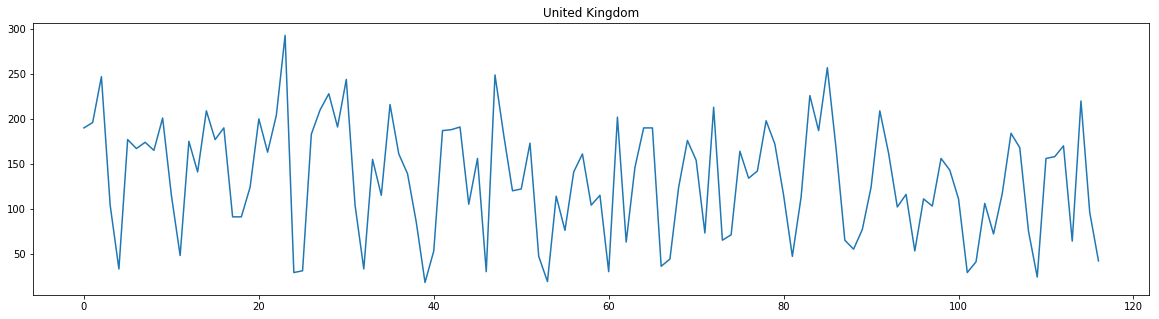

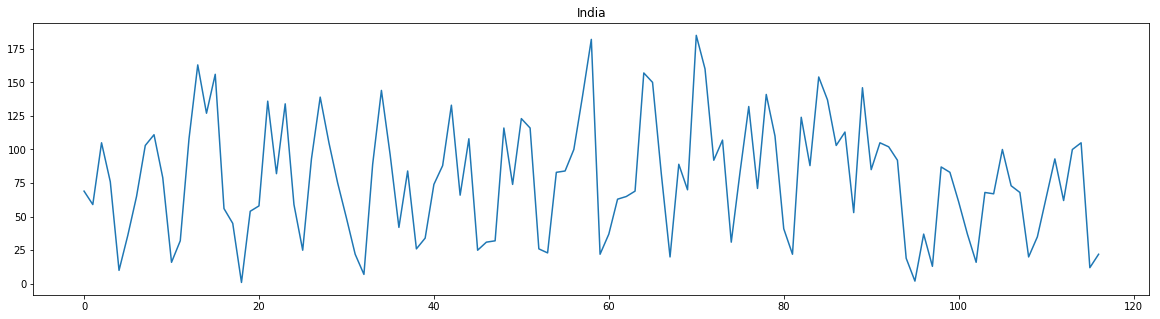

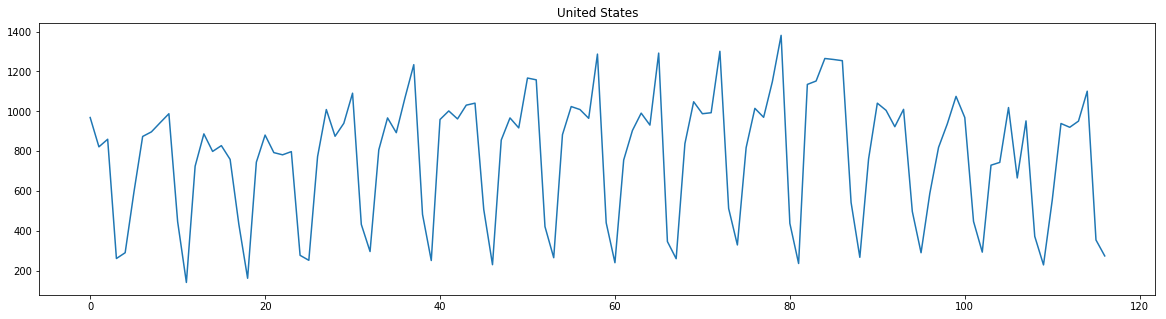

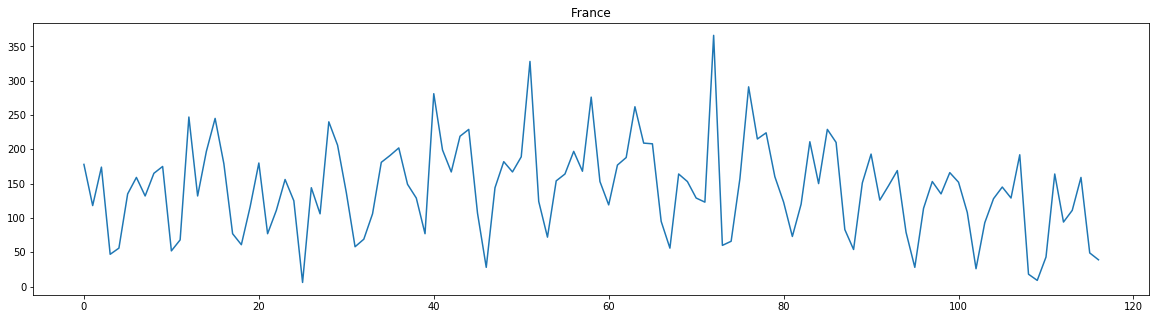

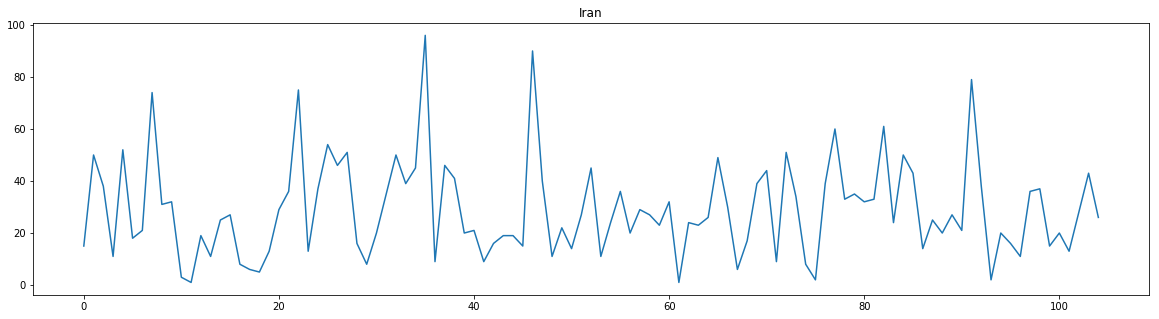

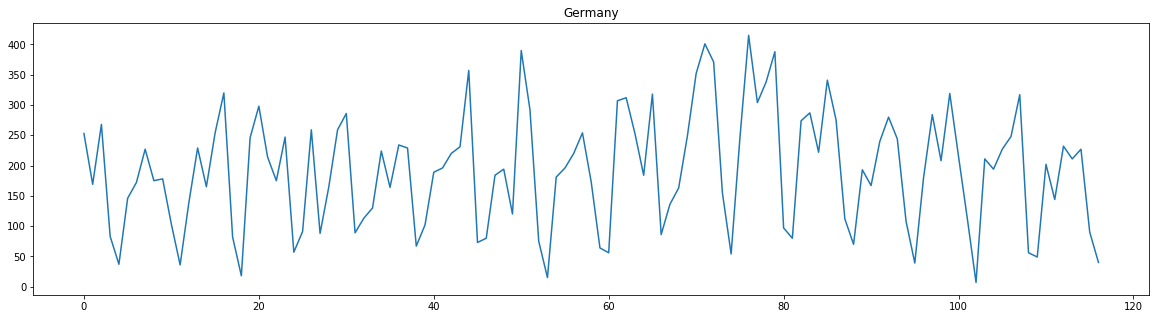

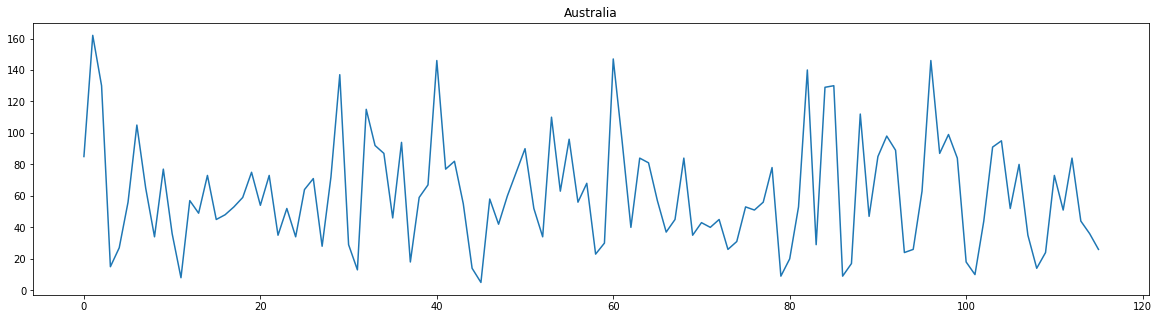

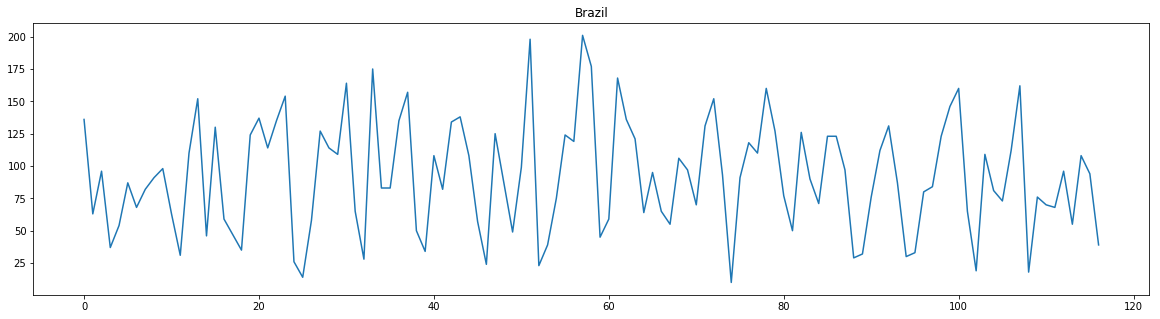

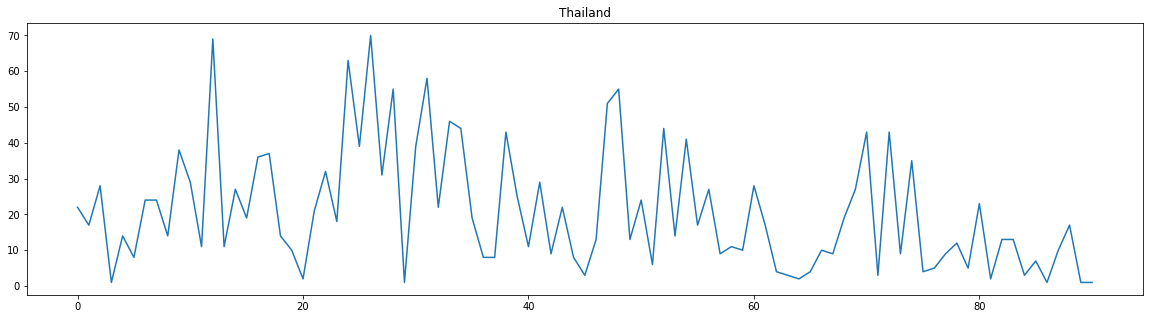

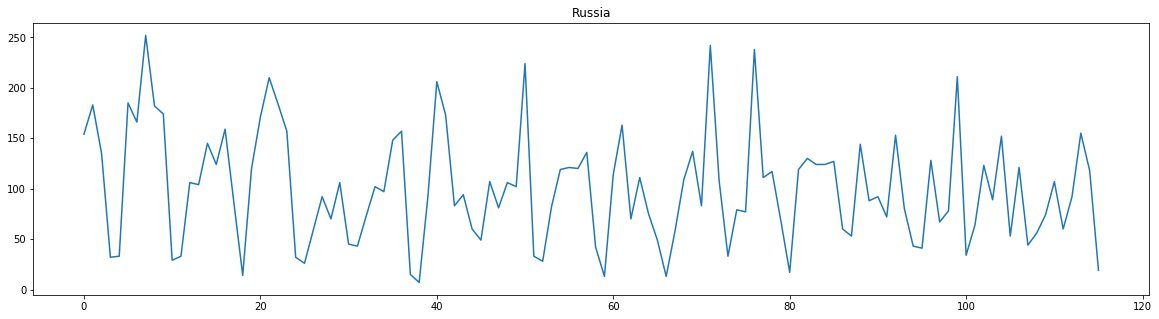

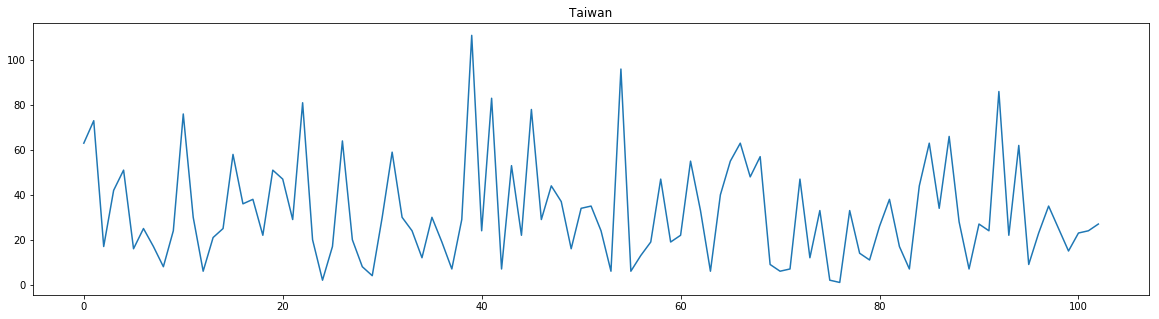

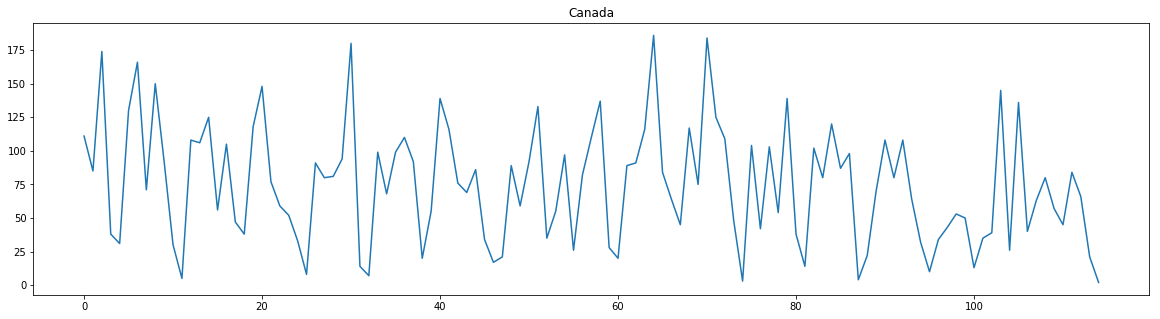

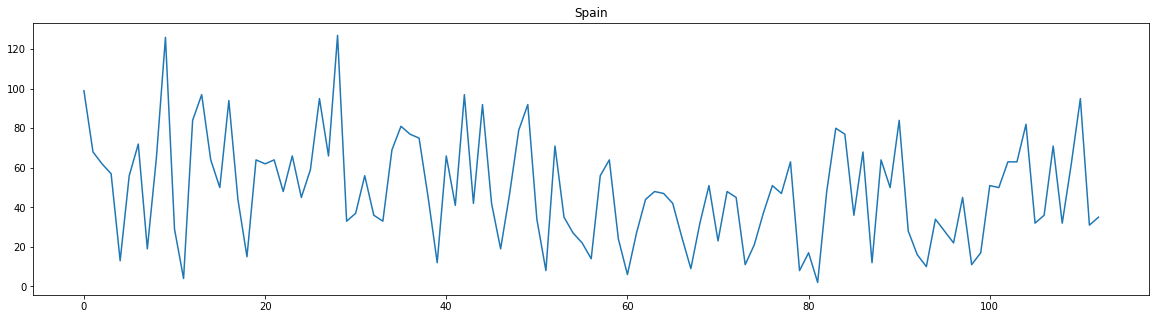

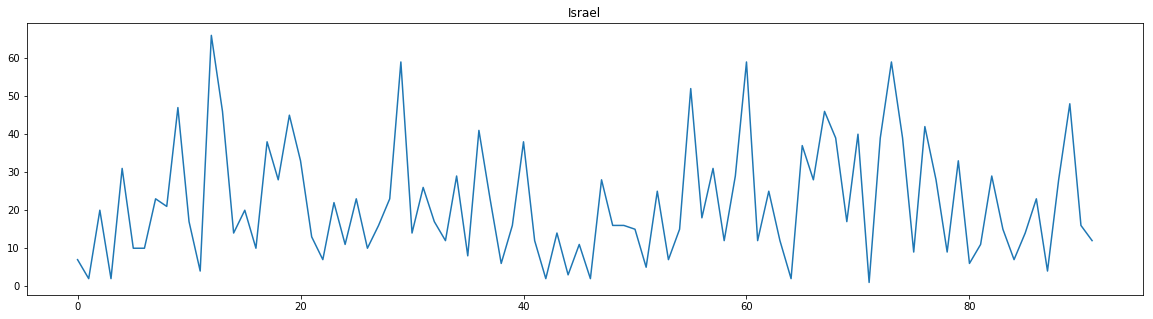

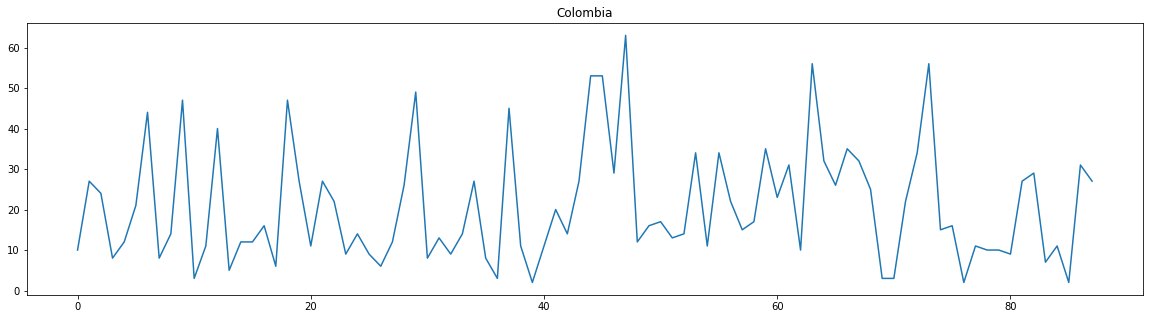

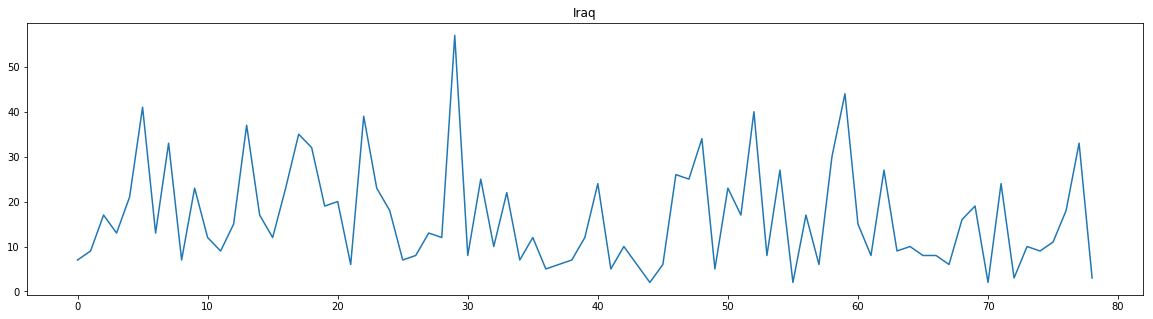

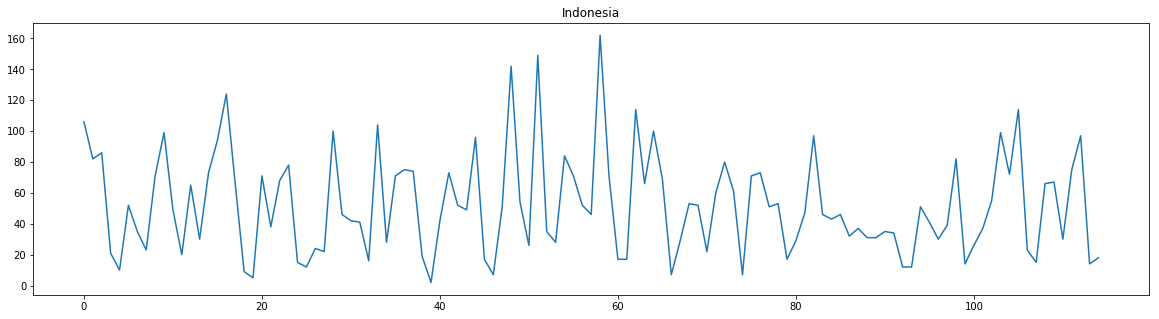

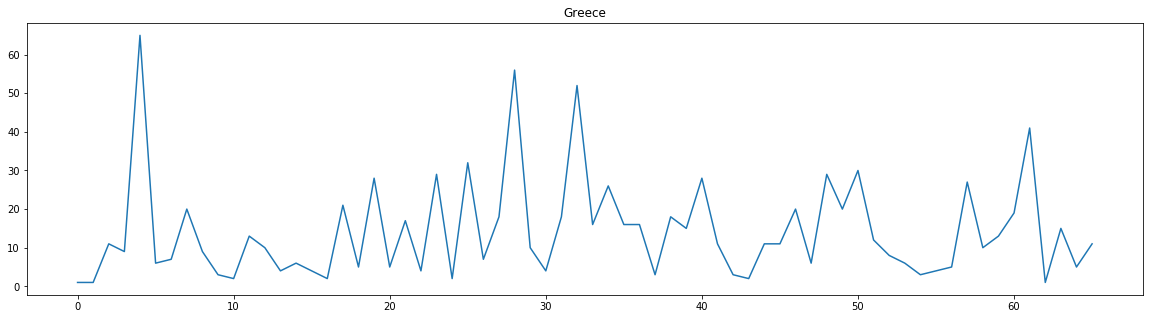

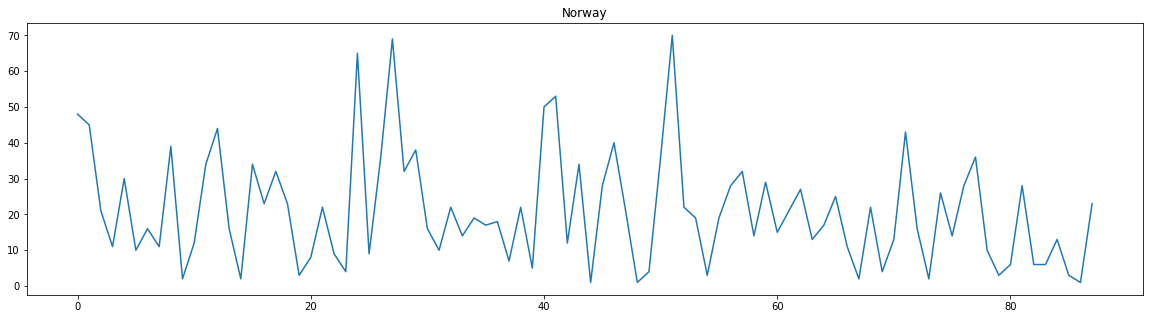

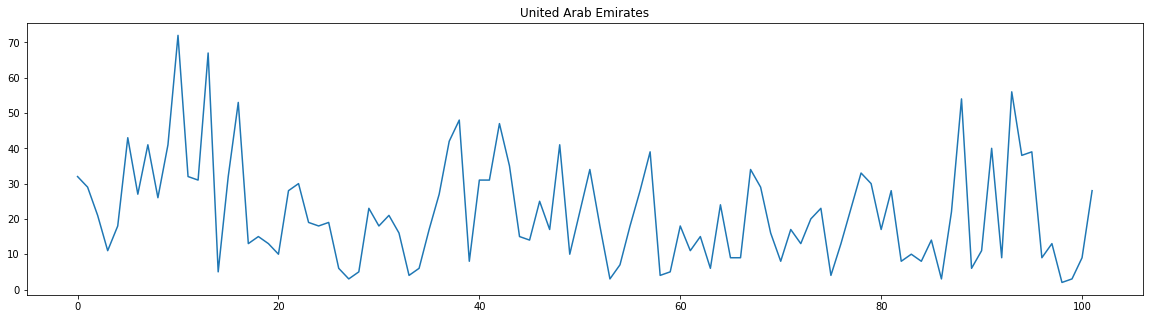

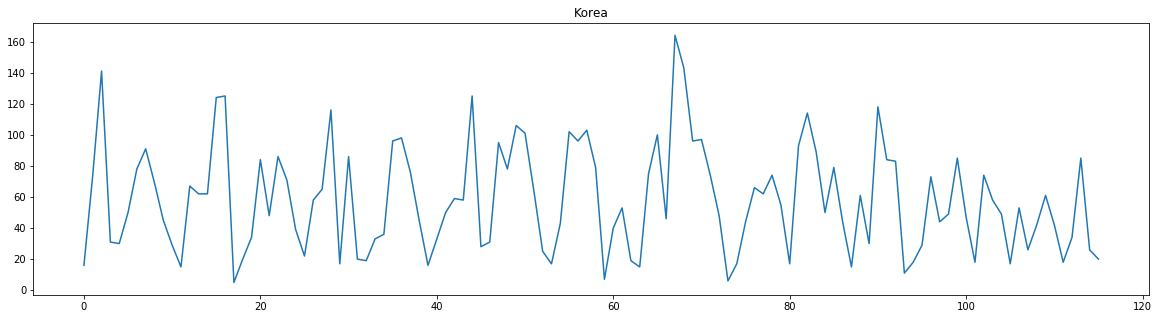

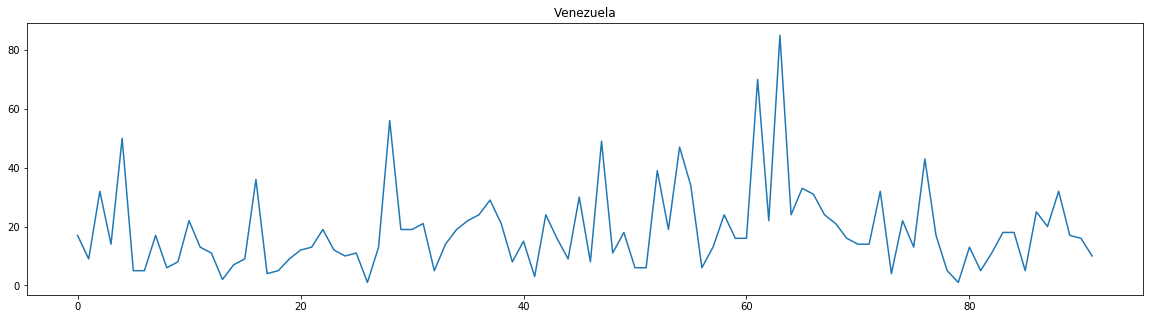

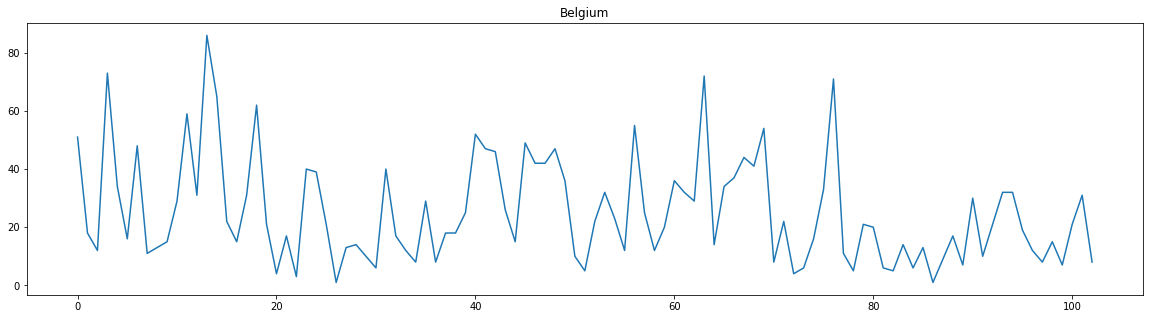

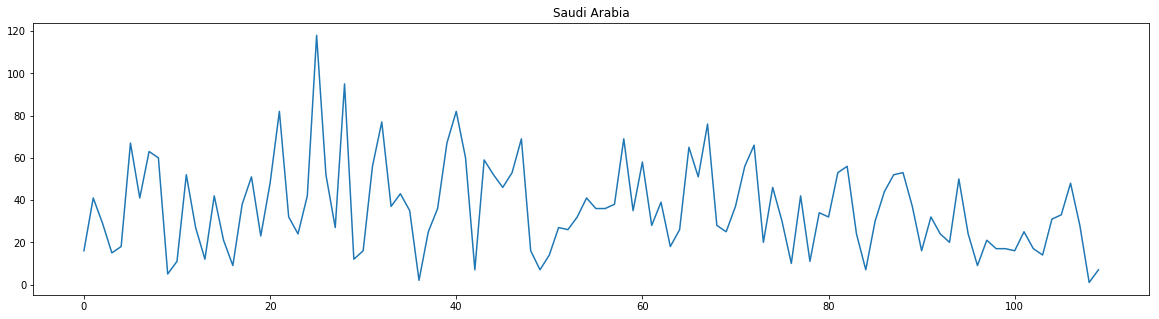

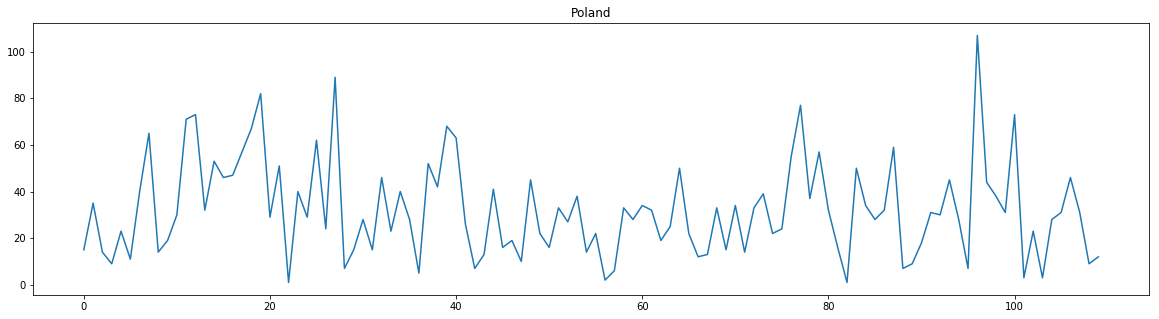

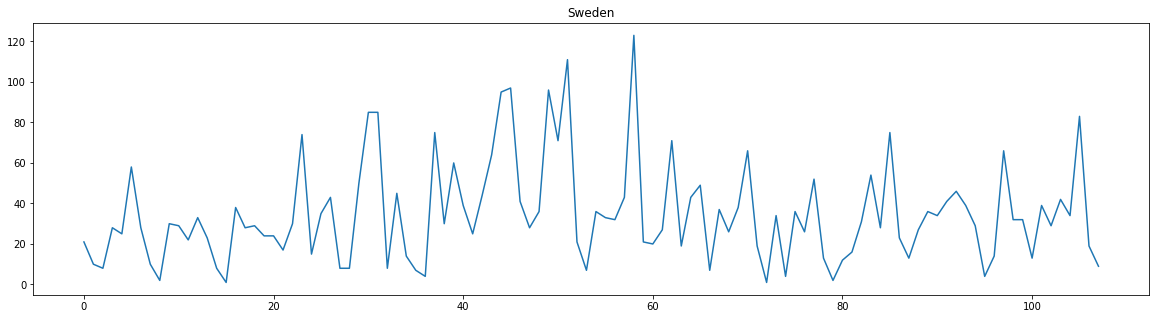

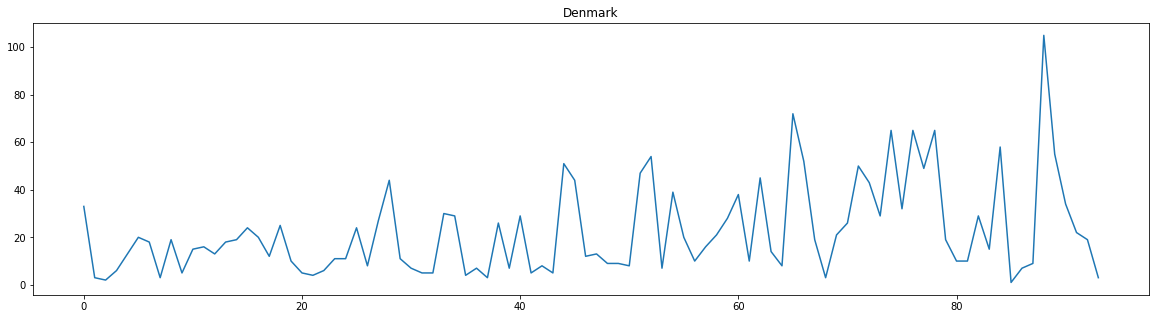

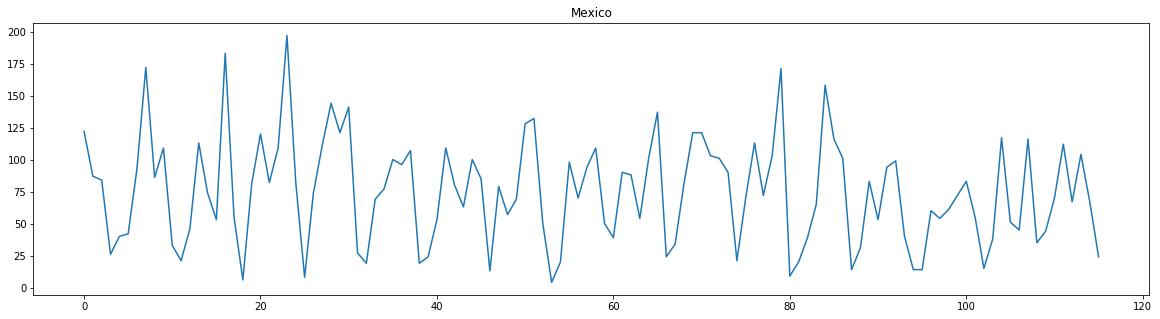

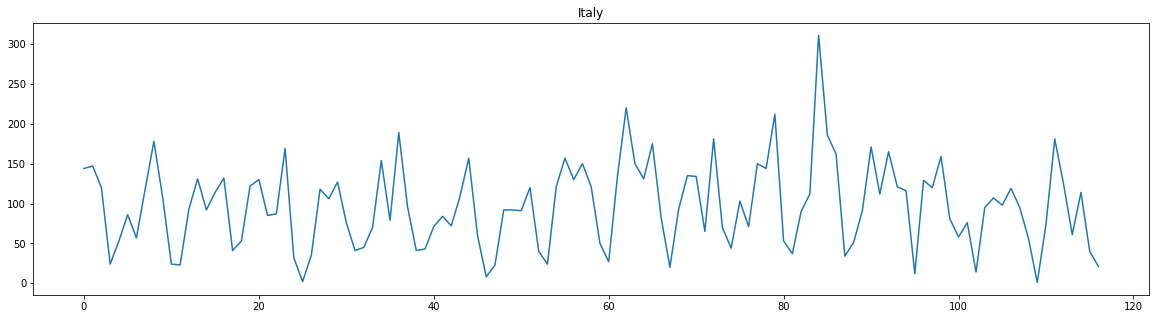

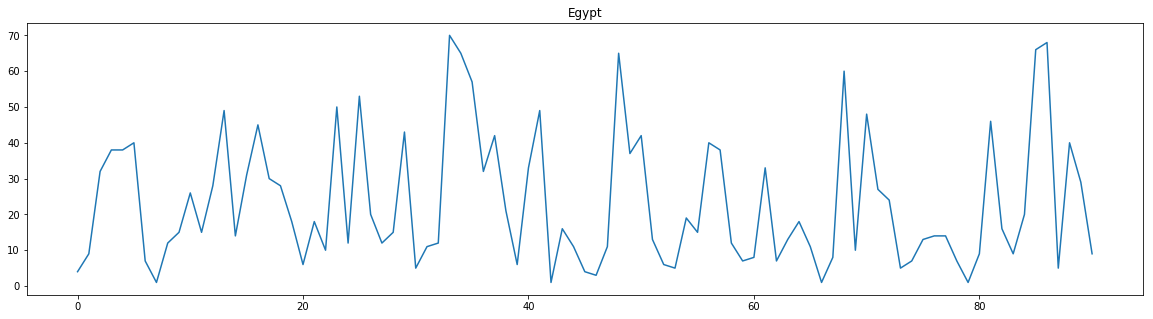

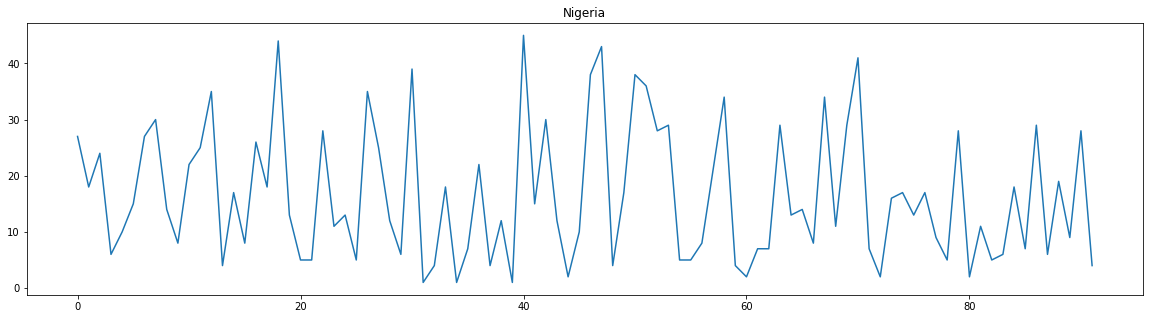

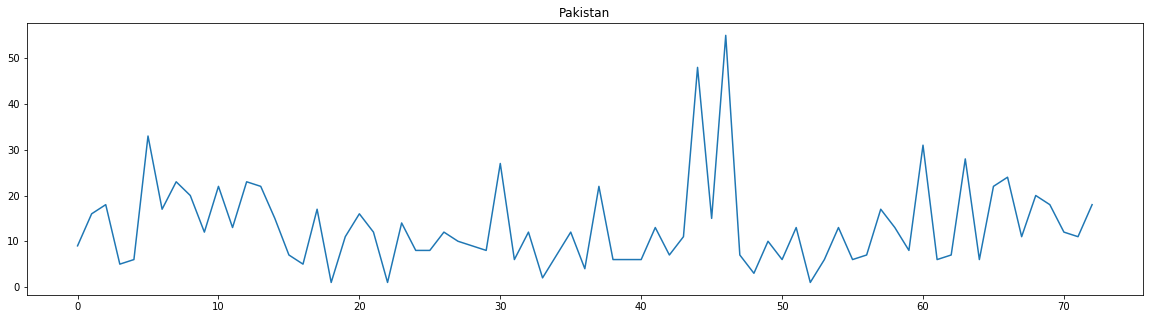

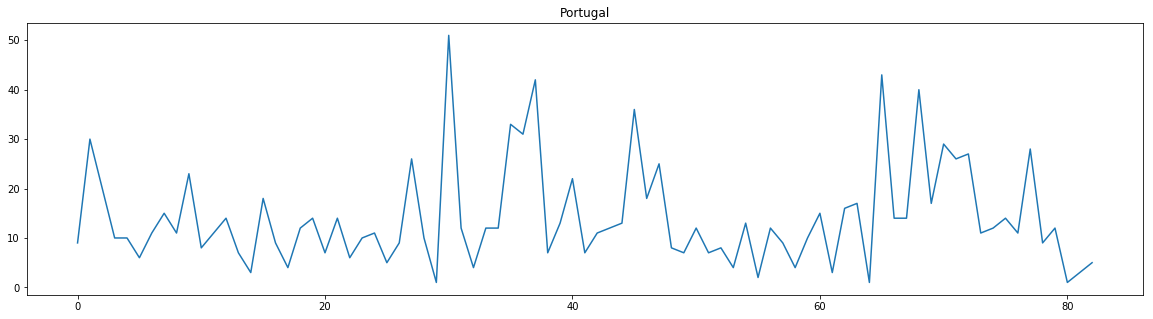

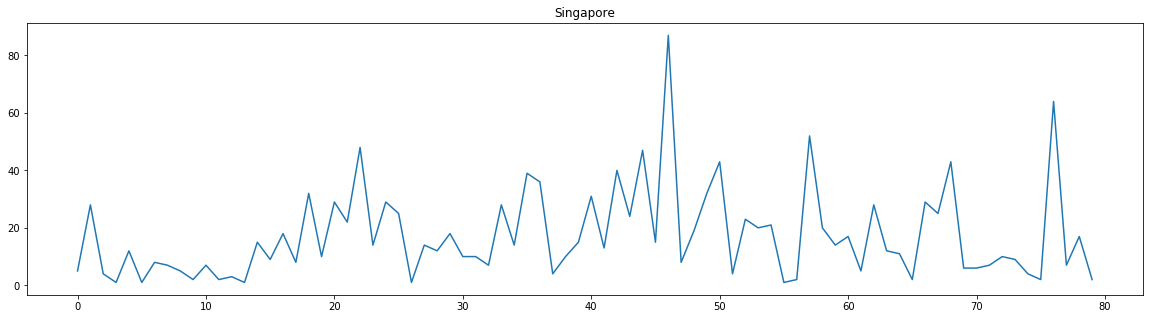

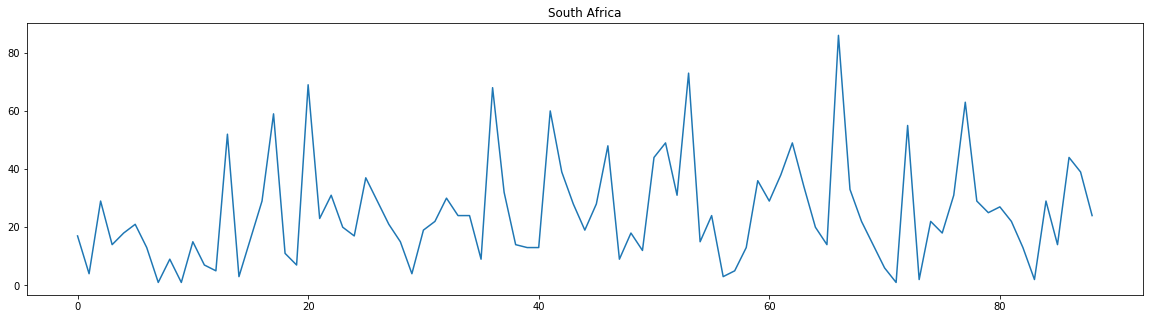

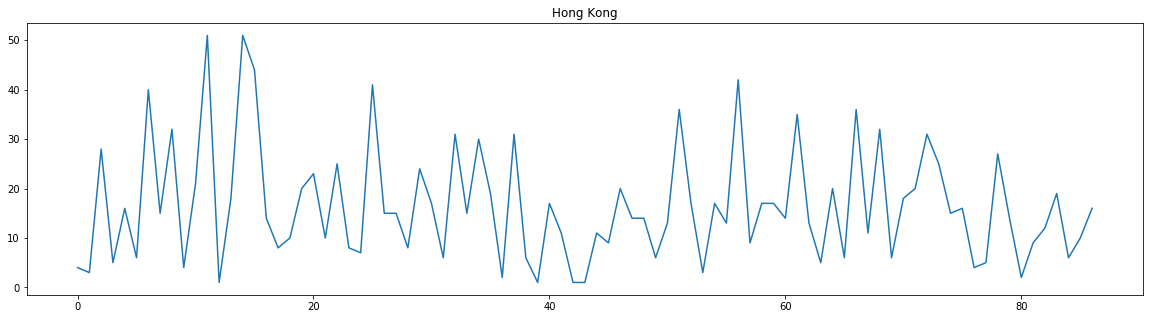

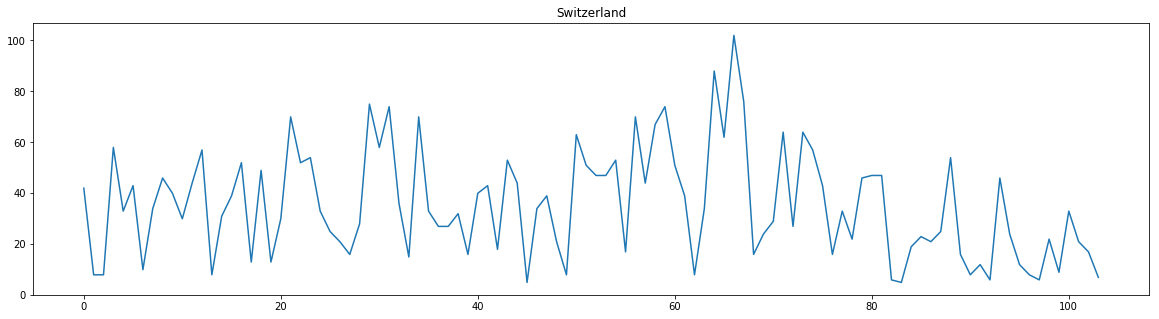

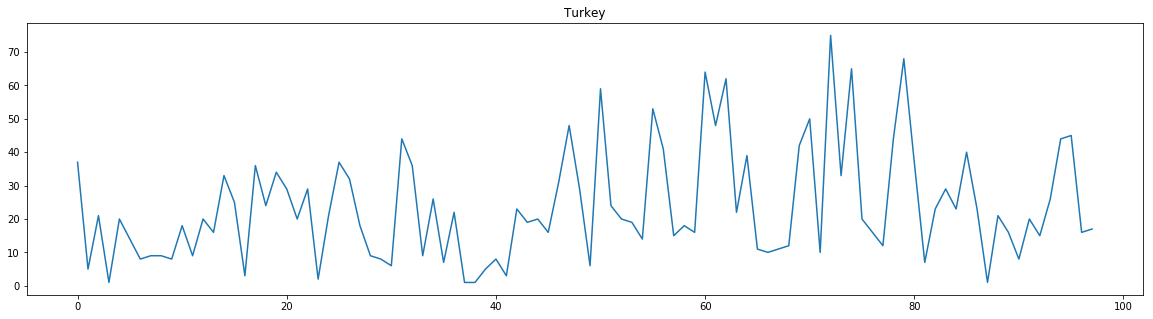

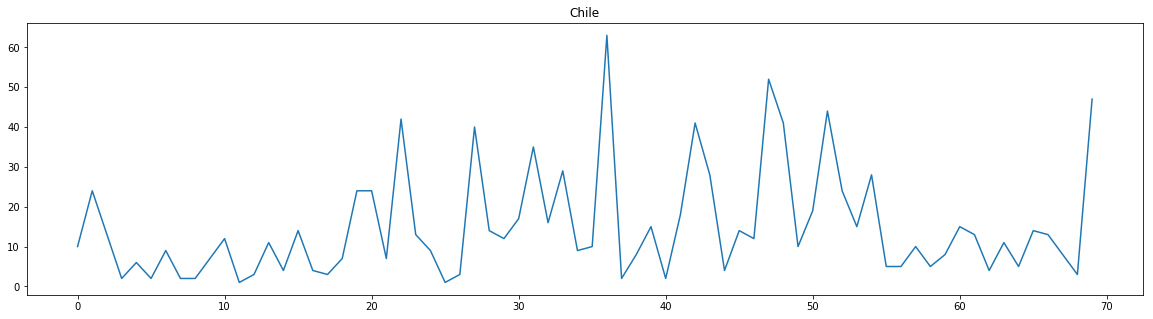

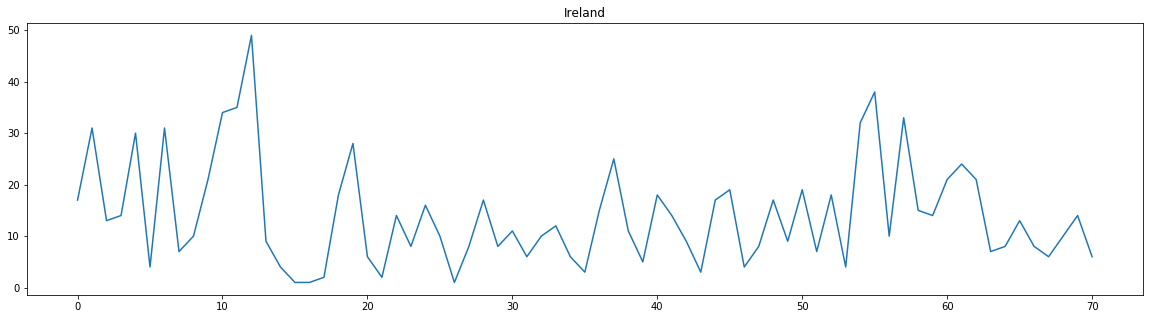

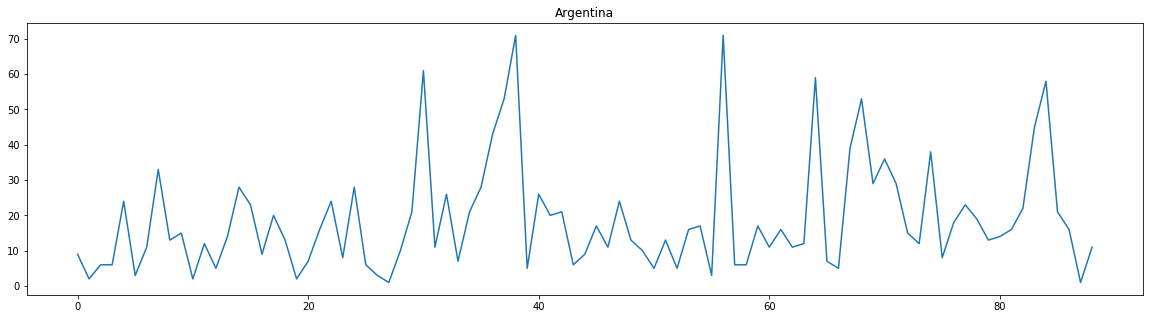

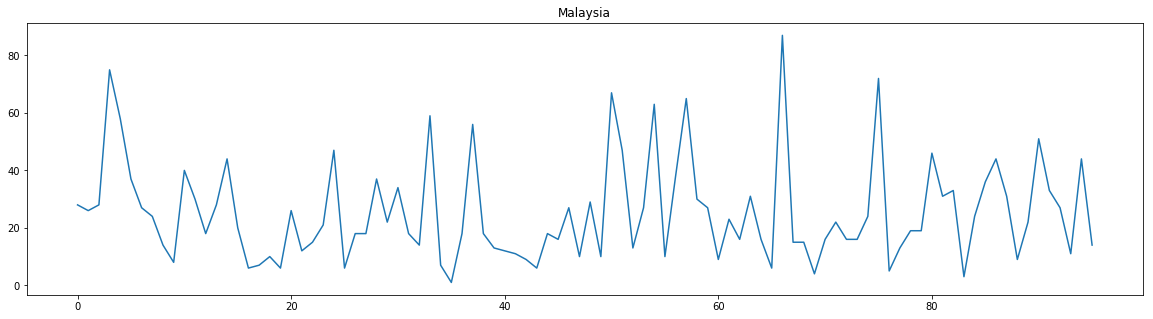

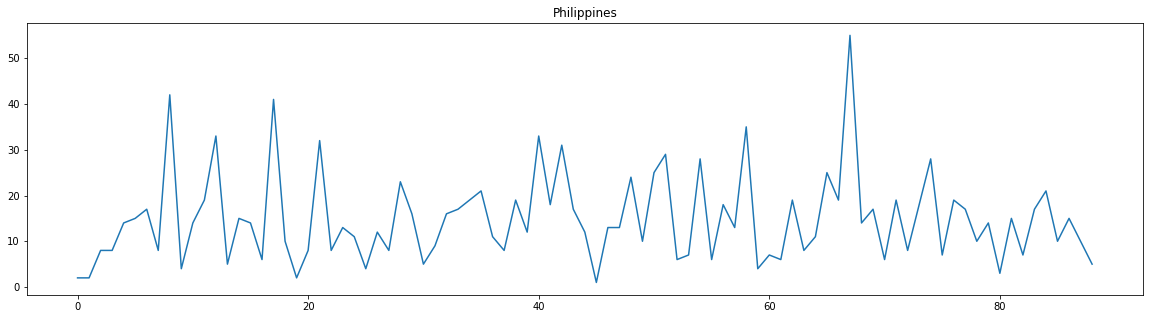

In [549]:
# Plot activity across COUNTRIES. Seven day rolling averages are visualized below.

for element in events_day['location'].unique():    
    test = events_day.loc[events_day['location'] == element].groupby([0]).count()
    moving_average = []
    date = []
    counts = test['occurred_at']
    i = 6
    while i < len(counts):
        average = (counts[i] + counts[i-1] + counts[i-2] + counts[i-3] + counts[i-4] + counts[i-5] + counts[i-6])/7
        day = daily_counts[0][i]
        moving_average.append(average)
        date.append(day)
        i += 1
    window = pd.DataFrame(moving_average).reset_index()
    month_day = pd.DataFrame(date).reset_index()
    #Plot of weekly-averaged engagement to recreate 
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.set_title(element)
    ax.plot(window['index'], window[0]);

In [551]:
events_day.head()

user_id          occurred_at  event_type    event_name location  \
0  10522.0  2014-05-02 11:02:39  engagement         login    Japan   
1  10522.0  2014-05-02 11:02:53  engagement     home_page    Japan   
2  10522.0  2014-05-02 11:03:28  engagement  like_message    Japan   
3  10522.0  2014-05-02 11:04:09  engagement    view_inbox    Japan   
4  10522.0  2014-05-02 11:03:16  engagement    search_run    Japan   

                   device  user_type           0  
0  dell inspiron notebook        3.0  2014-05-02  
1  dell inspiron notebook        3.0  2014-05-02  
2  dell inspiron notebook        3.0  2014-05-02  
3  dell inspiron notebook        3.0  2014-05-02  
4  dell inspiron notebook        3.0  2014-05-02

In [1]:
# Plot activity across EVENT NAME. Seven day rolling averages are visualized below.


for element in events_day['event_name'].unique():    
    test = events_day.loc[events_day['device'] == element].groupby([0]).count()
    moving_average = []
    date = []
    counts = test['occurred_at']
    i = 6
    while i < len(counts):
        average = (counts[i] + counts[i-1] + counts[i-2] + counts[i-3] + counts[i-4] + counts[i-5] + counts[i-6])/7
        day = daily_counts[0][i]
        moving_average.append(average)
        date.append(day)
        i += 1
    window = pd.DataFrame(moving_average).reset_index()
    month_day = pd.DataFrame(date).reset_index()
    #Plot of weekly-averaged engagement to recreate 
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.set_title(element)
    ax.plot(window['index'], window[0]);

NameError: name 'events_day' is not defined

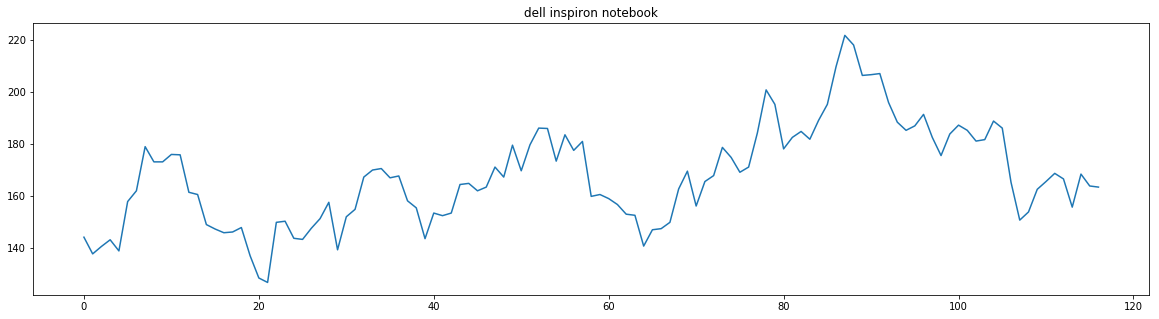

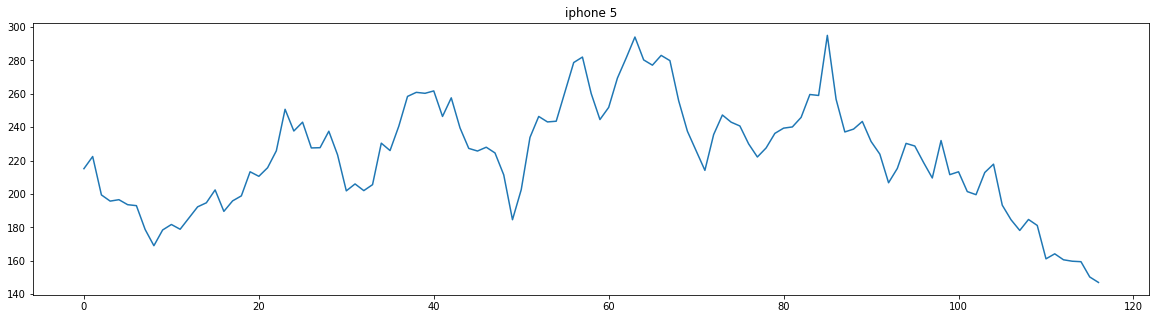

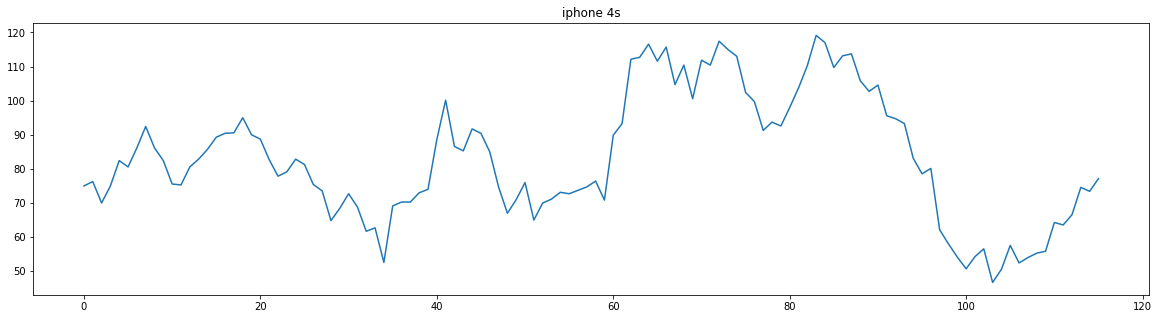

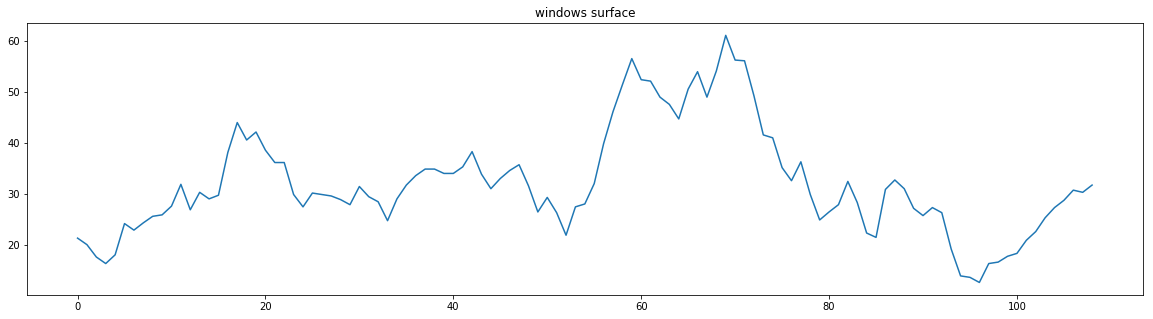

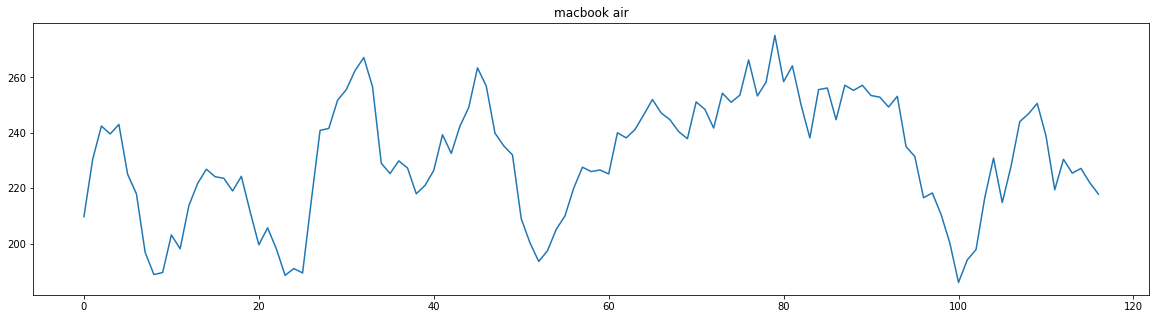

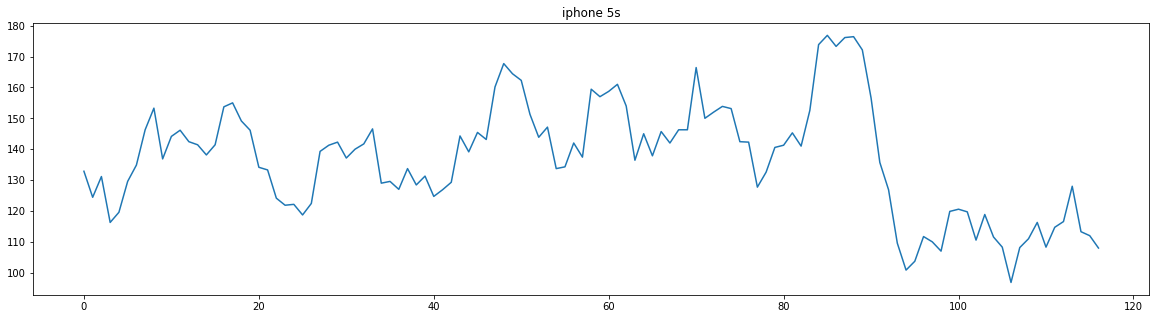

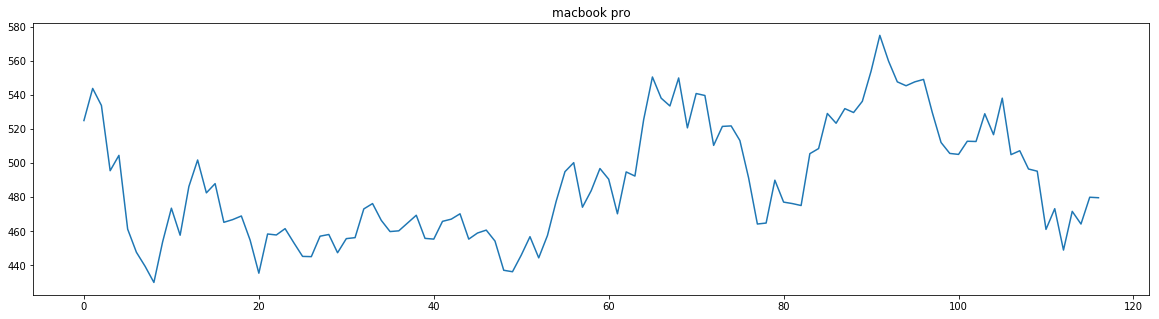

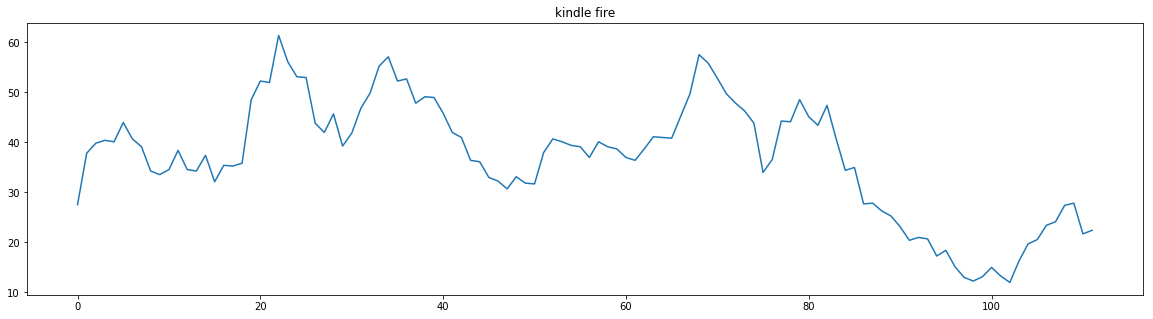

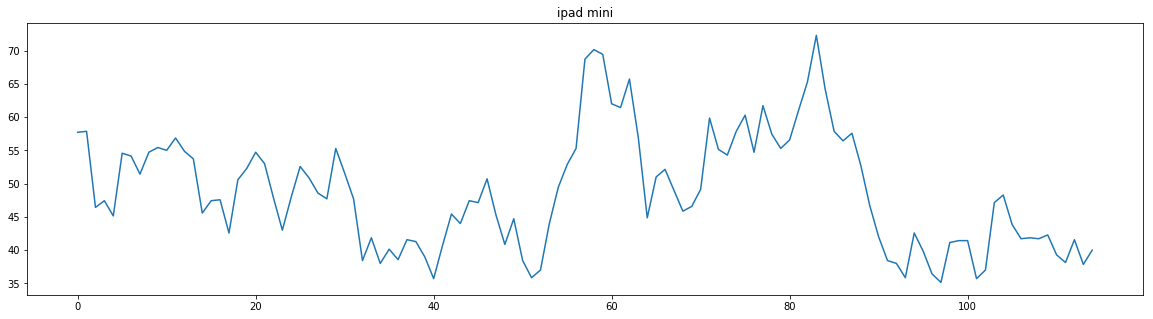

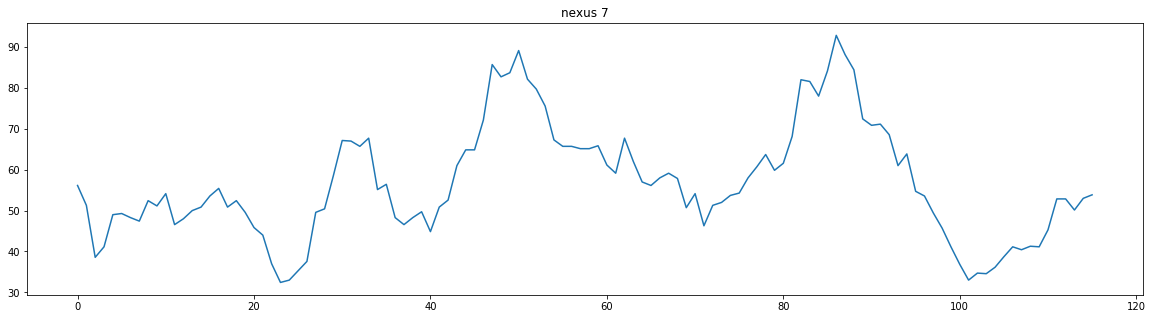

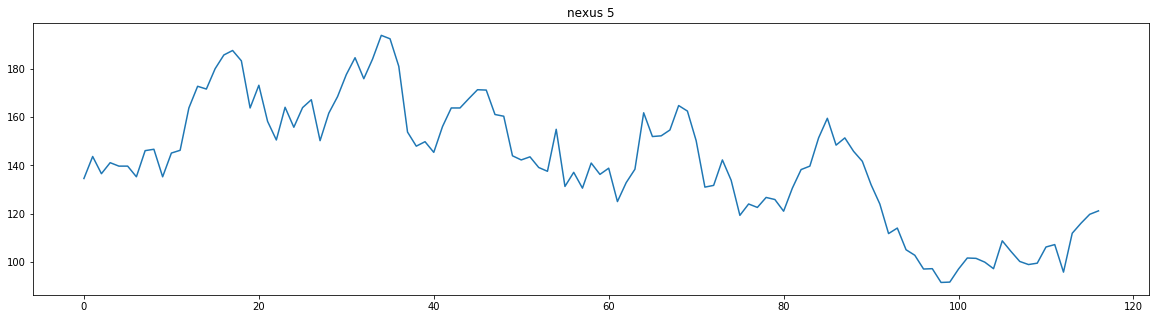

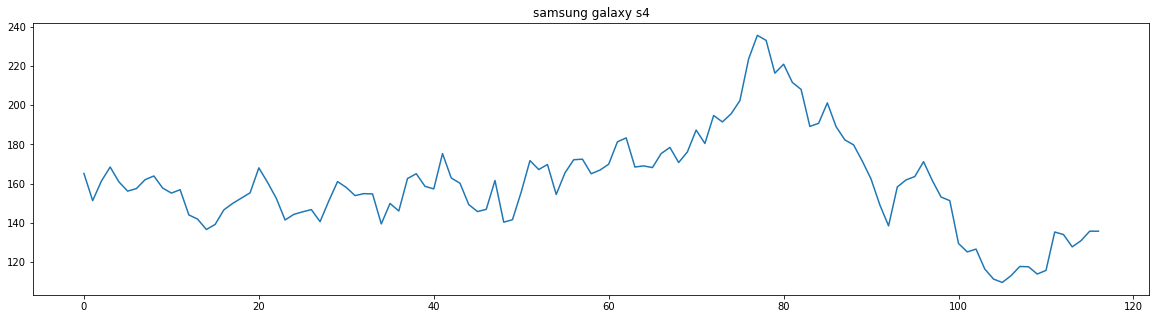

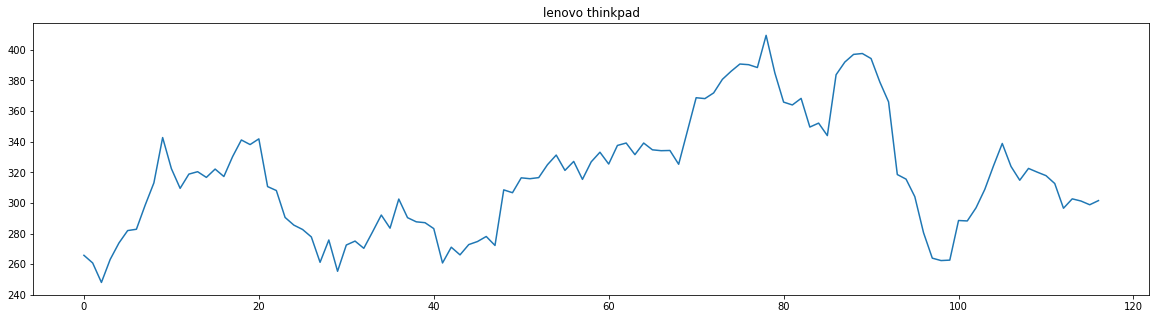

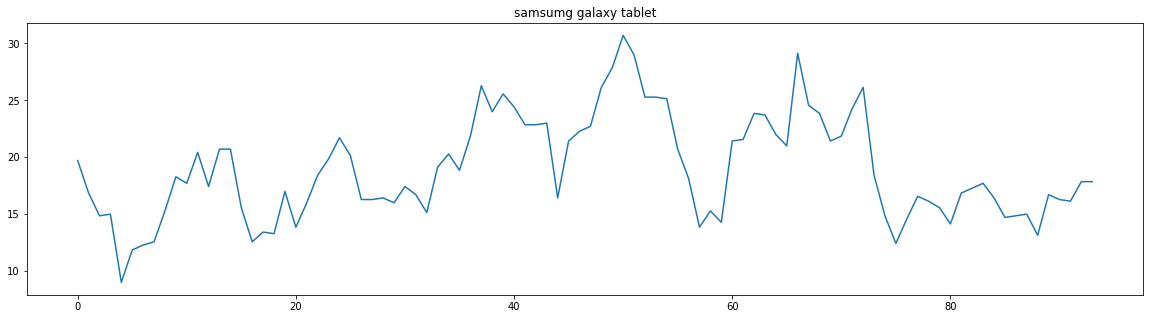

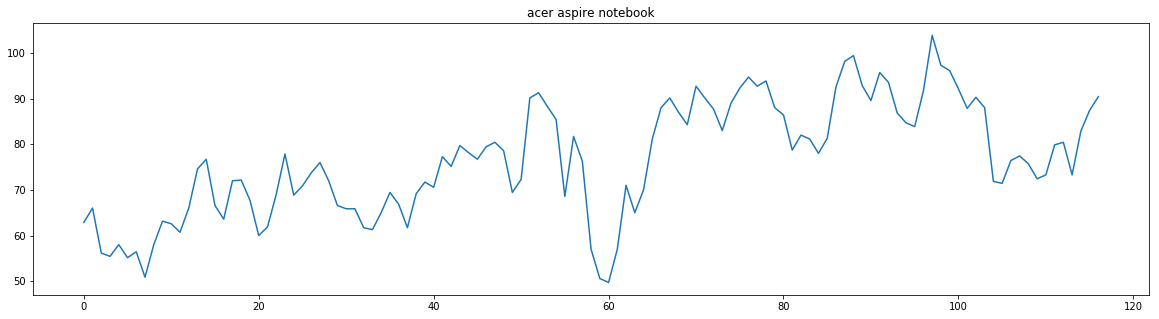

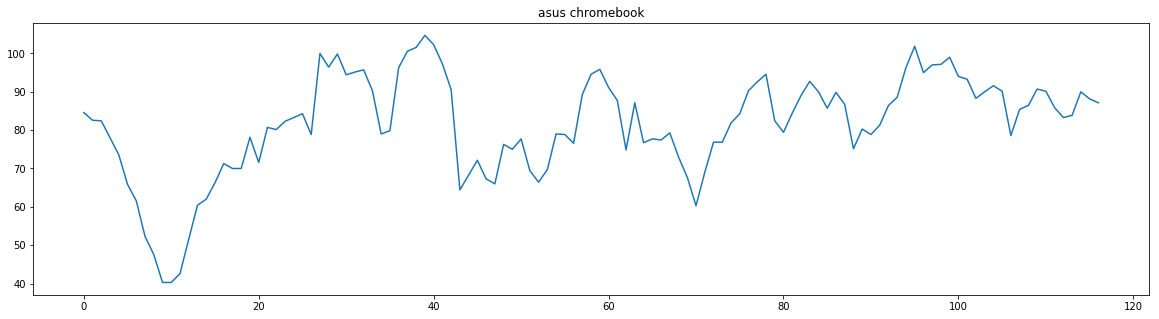

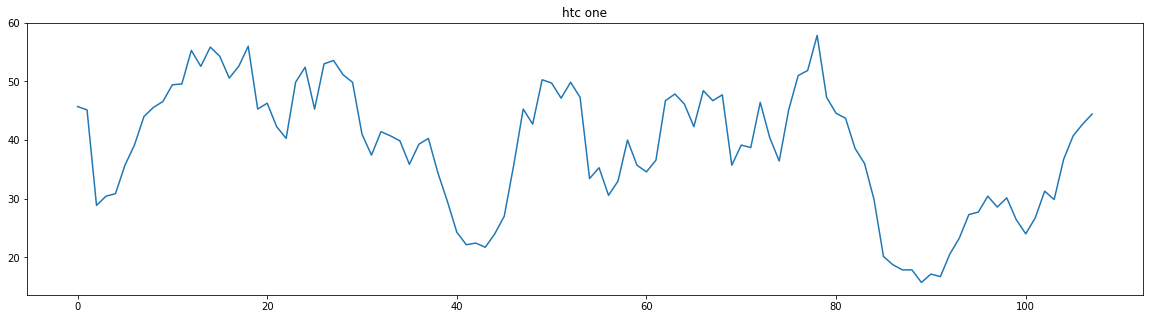

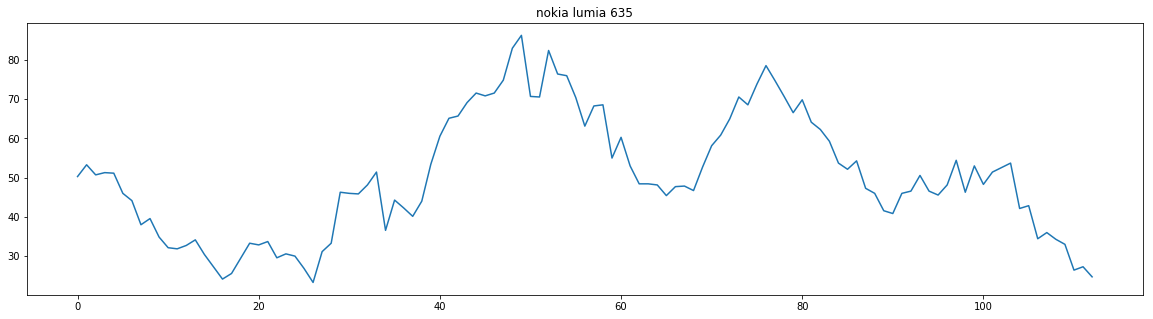

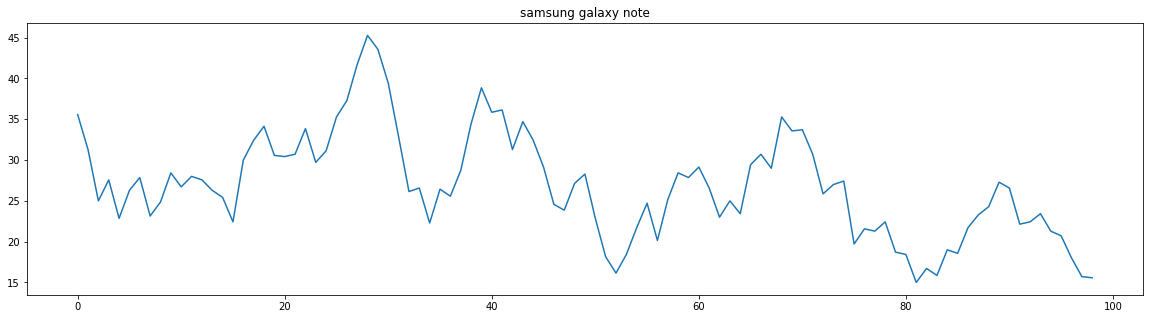

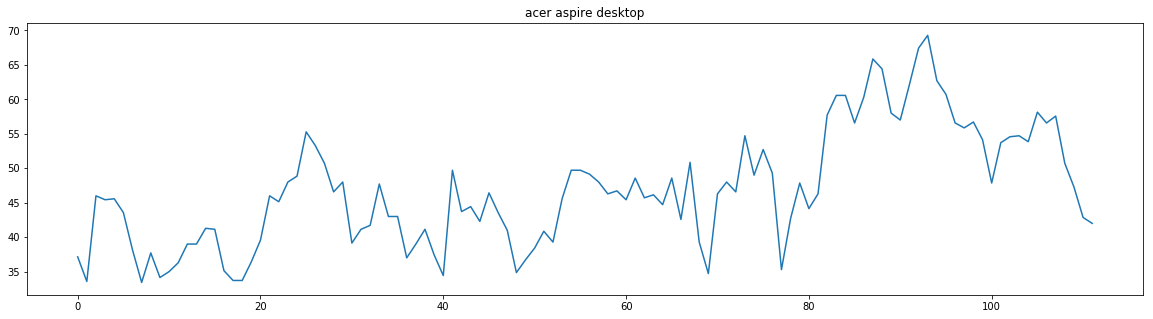

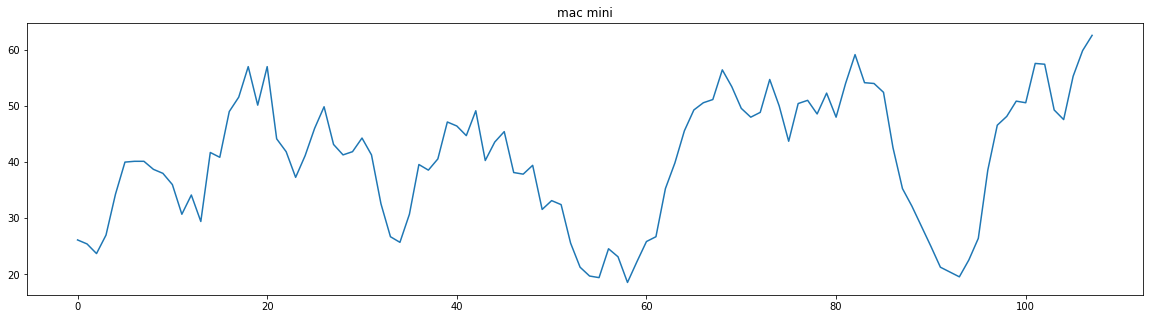

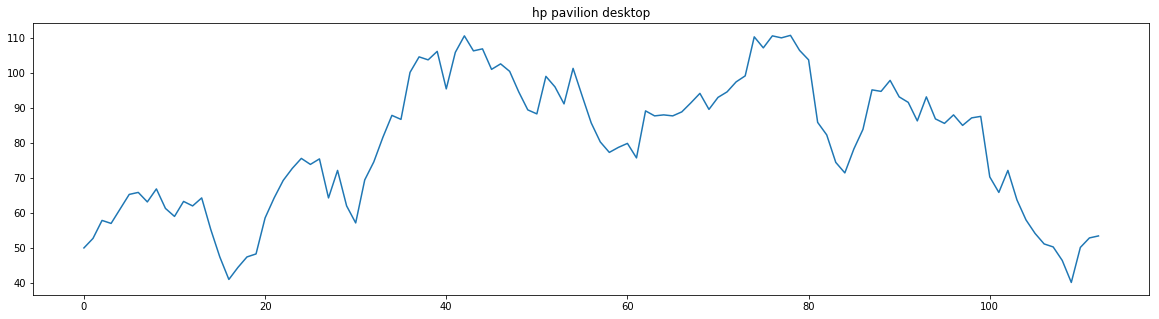

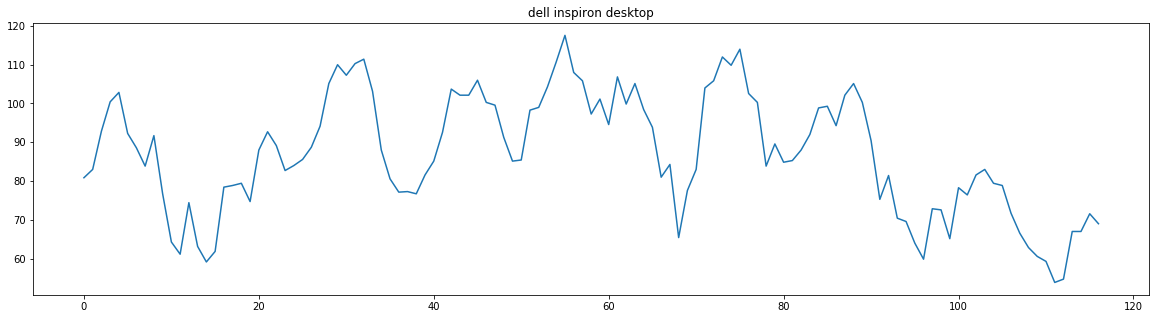

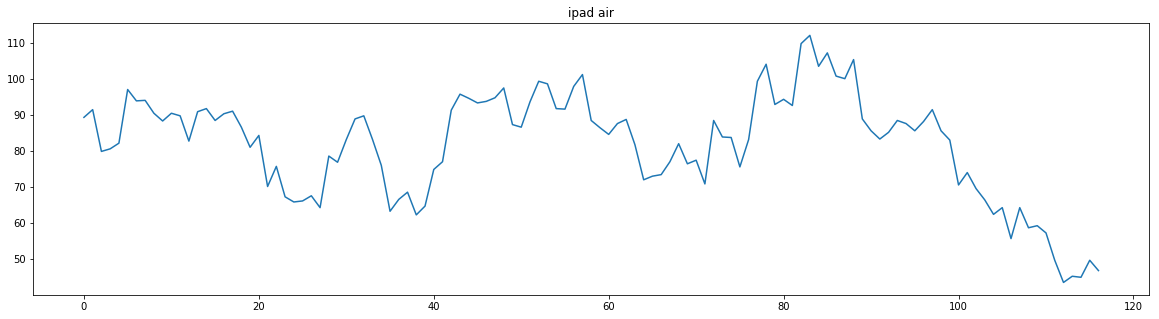

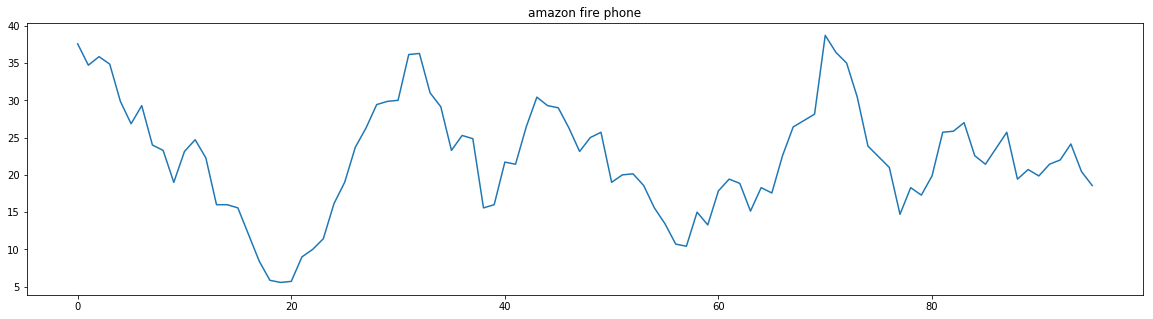

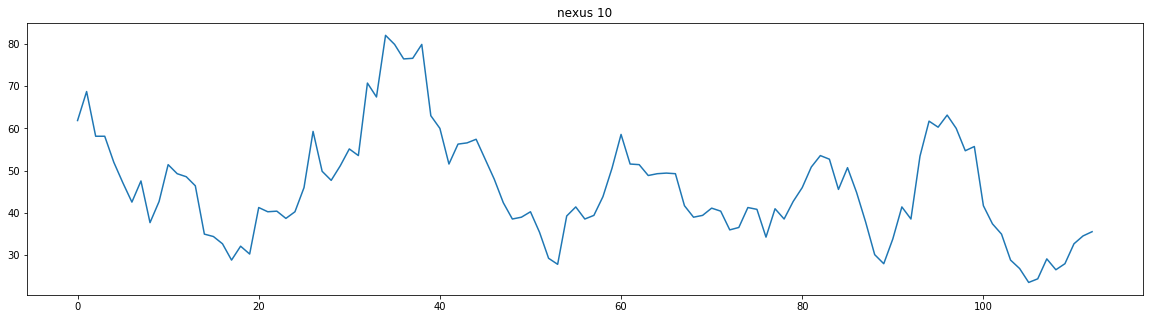

In [393]:
# Plot activity across DEVICE TYPE. Seven day rolling averages are visualized below.


for element in events_day['device'].unique():    
    test = events_day.loc[events_day['device'] == element].groupby([0]).count()
    moving_average = []
    date = []
    counts = test['occurred_at']
    i = 6
    while i < len(counts):
        average = (counts[i] + counts[i-1] + counts[i-2] + counts[i-3] + counts[i-4] + counts[i-5] + counts[i-6])/7
        day = daily_counts[0][i]
        moving_average.append(average)
        date.append(day)
        i += 1
    window = pd.DataFrame(moving_average).reset_index()
    month_day = pd.DataFrame(date).reset_index()
    #Plot of weekly-averaged engagement to recreate 
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.set_title(element)
    ax.plot(window['index'], window[0]);

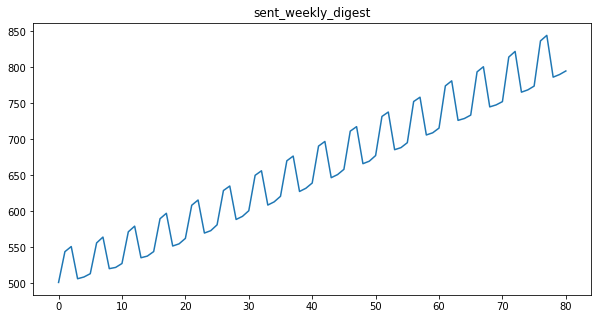

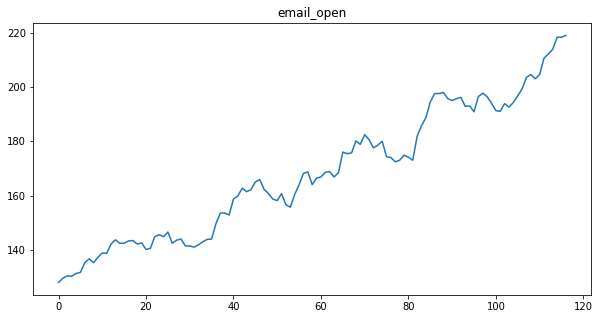

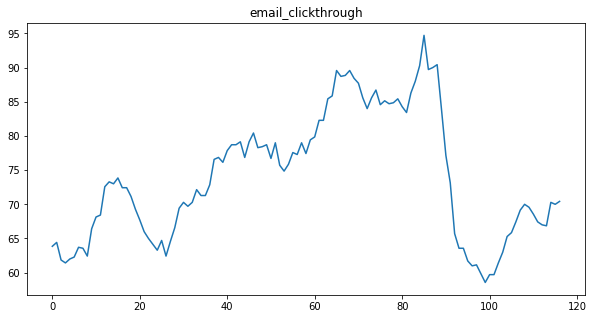

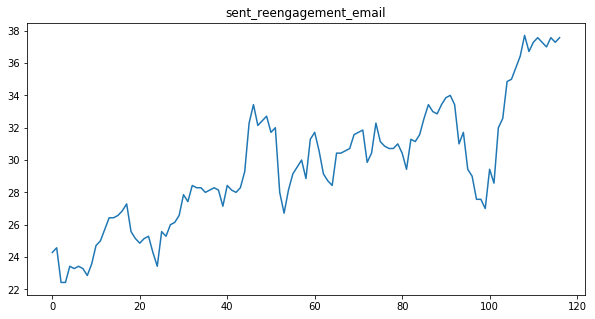

In [541]:
# Plot EMAIL activity. Seven day rolling averages are visualized below.

for element in emails_day['action'].unique(): 
    test = emails_day.loc[emails_day['action'] == element].groupby([0]).count()
    moving_average = []
    date = []
    counts = test['occurred_at']
    i = 6
    while i < len(counts):
        average = (counts[i] + counts[i-1] + counts[i-2] + counts[i-3] + counts[i-4] + counts[i-5] + counts[i-6])/7
        day = daily_counts[0][i]
        moving_average.append(average)
        date.append(day)
        i += 1
    window = pd.DataFrame(moving_average).reset_index()
    month_day = pd.DataFrame(date).reset_index()
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(element)
    ax.plot(window['index'], window[0]);

In [547]:
users.head()

user_id           created_at  company_id language         activated_at  \
0      0.0  2013-01-01 20:59:39      5737.0  english  2013-01-01 21:01:07   
1      1.0  2013-01-01 13:07:46        28.0  english                  NaN   
2      2.0  2013-01-01 10:59:05        51.0  english                  NaN   
3      3.0  2013-01-01 18:40:36      2800.0   german  2013-01-01 18:42:02   
4      4.0  2013-01-01 14:37:51      5110.0   indian  2013-01-01 14:39:05   

     state  
0   active  
1  pending  
2  pending  
3   active  
4   active